In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from glob import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from metpy.units import units
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.calc import mixing_ratio_from_relative_humidity

In [2]:
gfs = xr.open_dataset('/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/gfs_aggregate_all.nc')
gfs = gfs[['t', 'r', 'spd']].isel(level=np.where((gfs.level <= 750)&(gfs.level>=200))[0])

gfs['longitude'] = gfs['longitude'] - 360


gfs

<xarray.Dataset>
Dimensions:    (latitude: 81, level: 12, longitude: 121, time: 8879)
Coordinates:
  * level      (level) int64 200 250 300 350 400 450 500 550 600 650 700 750
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float64 -130.0 -129.8 -129.5 ... -100.5 -100.2 -100.0
  * time       (time) datetime64[ns] 2015-01-15T03:00:00 ... 2019-06-01
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    spd        (time, level, latitude, longitude) float32 ...

In [12]:
obs_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

interval = 24
site_list = ['CLN', 'AGD', 'ALTA', 'BCC', 'SLB', 'PVC', 'BSNFJE', 'BSNFDC', 'BSNFEX', 'CSSL']

metadata = pd.read_excel(obs_dir + 'Dataset_Metadata.xlsx')
metadata = metadata[np.in1d(metadata['code'], site_list)].set_index('code')

data = []

for site in site_list:
        
    site_metadata = metadata.loc[site, :]
    print('Working: ', site)
    
    gfs_profile = gfs.sel(latitude=site_metadata['lat'], longitude=site_metadata['lon'], method='nearest')
    gfs_profile_df = pd.DataFrame()
    
    for data_var in gfs_profile.data_vars:
        
        if 'level' in gfs_profile[data_var].coords:
            
            for level in gfs_profile.level:

                newname = '%s%s'%(data_var.upper(), level.values)

                if data_var == 'r':
                    p = level.values * units.millibar
                    t = gfs_profile['t'].sel(level=level).values * units.kelvin
                    r = gfs_profile[data_var].sel(level=level).values * units.percent

                    mixr = mixing_ratio_from_relative_humidity(r, t, p)
                    q = specific_humidity_from_mixing_ratio(mixr)

                    gfs_profile_df[newname.replace('R', 'Q')] = q

                else:
                    gfs_profile_df[newname] = gfs_profile[data_var].sel(level=level)
        
        else:
            newname = data_var.upper()
            gfs_profile_df[newname] = gfs_profile[data_var]

        gfs_profile_df['time'] = gfs_profile.time
        gfs_profile_df = gfs_profile_df.set_index('time')
    
    f = glob('{}/clean/{}*.pd'.format(obs_dir, site))[0]
    site_data = pd.read_pickle(f)
    
    # Key match
    if 'slr'+str(interval) in str(site_data.keys):
        _interval = interval
    else:
        _interval = 24 if interval == 12 else 12 
    
    site_data = site_data.loc[:, [k for k in site_data.keys() if str(_interval) in k]]
    
    site_data = site_data.dropna()
    site_data = site_data[~site_data.index.duplicated(keep='first')]
    
    index = gfs_profile_df.index
    site_data = site_data.iloc[np.where(site_data.index > index[0])]

    gfs_profile_df_reduced = []

    for t in site_data.index:

        t0 = t-timedelta(hours=_interval-3)

        time_slice = gfs_profile_df.iloc[(np.where((index >= t0)&(index <= t)))].mean()
        time_slice['datetime_utc'] = t

        gfs_profile_df_reduced.append(pd.DataFrame(time_slice).T)

    gfs_profile_df = pd.concat(gfs_profile_df_reduced).set_index('datetime_utc').sort_index()
    
    # Time match
    gfs_profile_df = gfs_profile_df[np.in1d(gfs_profile_df.index, site_data.index)]
    site_data = site_data[np.in1d(site_data.index, gfs_profile_df.index)]

    # Clean up
    gfs_profile_df = gfs_profile_df.loc[site_data[~site_data.duplicated()].index, :]
    site_data = site_data[~site_data.duplicated()]
    
    # Insert obs into profile
    for k in site_data.keys()[::-1]:
        gfs_profile_df.insert(0, k.replace('%d'%_interval, ''), site_data[k])

    gfs_profile_df = gfs_profile_df.dropna()

    print(gfs_profile_df.shape)
    
    data.append(gfs_profile_df)
    del gfs_profile_df
    
data = pd.concat(data)

swe_cutoff = 2.54 # 0.1"
data = data[data['swe_mm'] > swe_cutoff]

slr_cutoff_low = 1
data = data[data['slr'] >= slr_cutoff_low]

slr_cutoff_high = 40
data = data[data['slr'] <= slr_cutoff_high]

for k in ['depth_mm', 'snow_mm']:#, 'swe_mm']:
    try:
        data.pop(k)
    except:
        pass

# # Any transforms need to happen here!
# # data['swe_mm'] = np.log(data['swe_mm'])
# data['slr'] = np.log(data['slr'])

data

Working:  CLN
(417, 40)
Working:  AGD
(517, 39)
Working:  ALTA
(439, 40)
Working:  BCC
(344, 39)
Working:  SLB
(284, 40)
Working:  PVC
(289, 39)
Working:  BSNFJE
(104, 40)
Working:  BSNFDC
(124, 40)
Working:  BSNFEX
(147, 40)
Working:  CSSL
(40, 39)


,slr,swe_mm,T200,T250,T300,T350,T400,T450,T500,T550,...,SPD300,SPD350,SPD400,SPD450,SPD500,SPD550,SPD600,SPD650,SPD700,SPD750
datetime_utc,,,,,,,,,,,,,,,,,,,,,
2015-01-16 21:00:00,6.520000,5.84,210.65,218.025,228.25,237.312,244.738,251,256.463,261.125,...,22.656,21.1747,21.355,20.4714,18.954,17.6534,15.1694,11.4507,8.1278,5.5487
2015-01-28 21:00:00,5.880000,4.32,224.337,224.462,229.287,236.975,243.8,249.25,254.175,258.112,...,25.1971,23.3277,19.3045,15.4116,12.6885,11.4893,9.6969,8.99433,7.94047,6.70809
2015-01-30 21:00:00,10.520000,4.83,216.213,219.15,229.538,238.162,245.275,250.85,255.138,259.1,...,29.4559,19.2612,12.7762,9.13224,7.15056,5.99615,5.01832,4.60638,3.71416,2.75488
2015-02-02 21:00:00,6.580000,9.65,211.713,216.925,226.738,235.275,242.625,249.113,254.375,258.788,...,34.5733,30.4956,26.6955,23.7524,21.4951,20.1708,17.9606,13.0899,6.87054,4.02562
2015-02-03 21:00:00,7.320000,10.41,208.562,215.737,225.712,234.75,242.712,249.363,254.85,259.337,...,30.854,27.4483,24.9906,22.362,19.825,18.4259,16.1975,11.8943,7.47052,4.90518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-04 08:00:00,7.394366,71.00,228.338,225.314,226.184,231.037,236.703,242.197,247.622,252.575,...,42.1721,37.6076,30.7853,26.2912,24.2372,22.6736,22.4694,22.1934,20.4639,14.2131
2019-02-09 08:00:00,1.466667,75.00,221.584,219.214,219.576,223.939,230.998,237.791,243.818,249.3,...,21.6512,17.6801,15.4978,12.9581,10.4381,9.34596,9.86298,10.5268,10.8856,6.0259
2019-02-15 08:00:00,8.214286,28.00,223.401,226.248,228.998,233.434,239.557,245.514,250.883,255.356,...,55.4009,47.1615,43.1128,40.0132,36.8701,33.4995,31.0735,29.8828,27.1628,19.9803


In [41]:
# from sklearn.linear_model import LinearRegression

# x, y = data['swe_mm'], data['slr']
# nn = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y))[0]
# x, y = x.values[nn].reshape(-1, 1), y.values[nn]

# lr = LinearRegression()
# lr.fit(x, y)

# lr_train_score = lr.score(x, y)
# print(lr_train_score)
# # lr_test_score = lr.score(x, y)

# plt.scatter(x, y)
# plt.grid()
# plt.show()

In [42]:
# x, y = np.log(data['swe_mm']), np.log(data['slr'])
# nn = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y))[0]
# x, y = x.values[nn].reshape(-1, 1), y.values[nn]

# lr = LinearRegression()
# lr.fit(x, y)

# lr_train_score = lr.score(x, y)
# print(lr_train_score)
# # lr_test_score = lr.score(x, y)

# plt.scatter(x, y)
# plt.grid()
# plt.show()

In [13]:
from sklearn.model_selection import train_test_split

fac = 10
slr_strata = np.round(data['slr']/fac, 0)*fac
slr_strata.value_counts()

# Train/Test/Validate split
X_train, X_test = train_test_split(data, 
                                       test_size=0.4, train_size=0.6, 
                                       random_state=None, stratify=slr_strata)

y_train, y_test = X_train.pop('slr'), X_test.pop('slr')

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

Train: 1267
Test: 845
Validate: None


In [14]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler().fit(X_train)
# scaler = RobustScaler(quantile_range=(25, 75)).fit(X_train)

X_train_norm = pd.DataFrame(scaler.transform(X_train.loc[:, list(X_train.keys())]), columns=X_train.keys())
X_test_norm = pd.DataFrame(scaler.transform(X_test.loc[:, list(X_train.keys())]), columns=X_train.keys())

X_train_norm.describe().T.head(100)

,count,mean,std,min,25%,50%,75%,max
swe_mm,1267.0,3.925650e-17,1.000395,-0.936250,-0.690240,-0.307045,0.348984,8.602229
T200,1267.0,-2.243229e-16,1.000395,-2.407915,-0.725859,-0.014287,0.736238,2.539641
T250,1267.0,-2.938630e-15,1.000395,-2.955647,-0.719043,-0.180782,0.629140,3.237062
T300,1267.0,2.405863e-15,1.000395,-3.066965,-0.607532,0.000661,0.658119,3.282373
T350,1267.0,-3.275114e-15,1.000395,-3.065924,-0.616794,0.054090,0.704927,2.901196
T400,1267.0,2.753563e-15,1.000395,-2.950185,-0.595910,0.115569,0.727982,2.493714
T450,1267.0,-2.355390e-15,1.000395,-2.981069,-0.602053,0.142896,0.722056,2.260971
T500,1267.0,-3.561126e-16,1.000395,-3.078536,-0.625318,0.171313,0.730266,2.249858
T550,1267.0,2.459140e-15,1.000395,-3.011156,-0.645780,0.147905,0.734138,2.217162
T600,1267.0,3.981731e-16,1.000395,-2.788508,-0.630166,0.124442,0.732105,2.147289


In [15]:
X_train_norm = X_train_norm.dropna()
y_train = y_train.iloc[X_train_norm.index.values]

X_test_norm = X_test_norm.dropna()
y_test = y_test.iloc[X_test_norm.index.values]

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_norm, y_train)

lr_train_score = lr.score(X_train_norm, y_train)
lr_test_score = lr.score(X_test_norm, y_test)

print('Linear Regression Train Score: %.3f'%lr_train_score)
print('Linear Regression Test Score: %.3f'%lr_test_score)

Linear Regression Train Score: 0.386
Linear Regression Test Score: 0.359


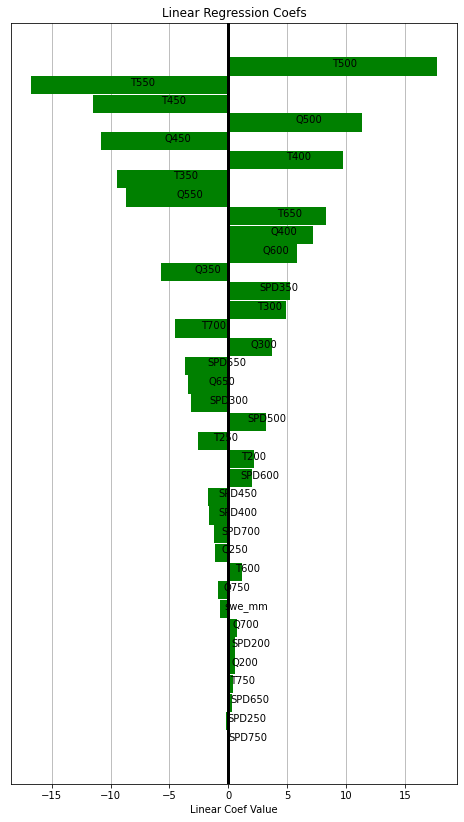

In [17]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lr.coef_))[::-1]
lr_coefs = lr.coef_[ranksort]
lr_keys = X_train_norm.keys()[ranksort]
mask = lr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lr_keys[mask], lr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lr_keys[mask]):
    if lr_coefs[i] != 0:
        ax.text(lr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Linear Regression Coefs')
ax.set_xlabel('Linear Coef Value')
ax.grid(zorder=-1)

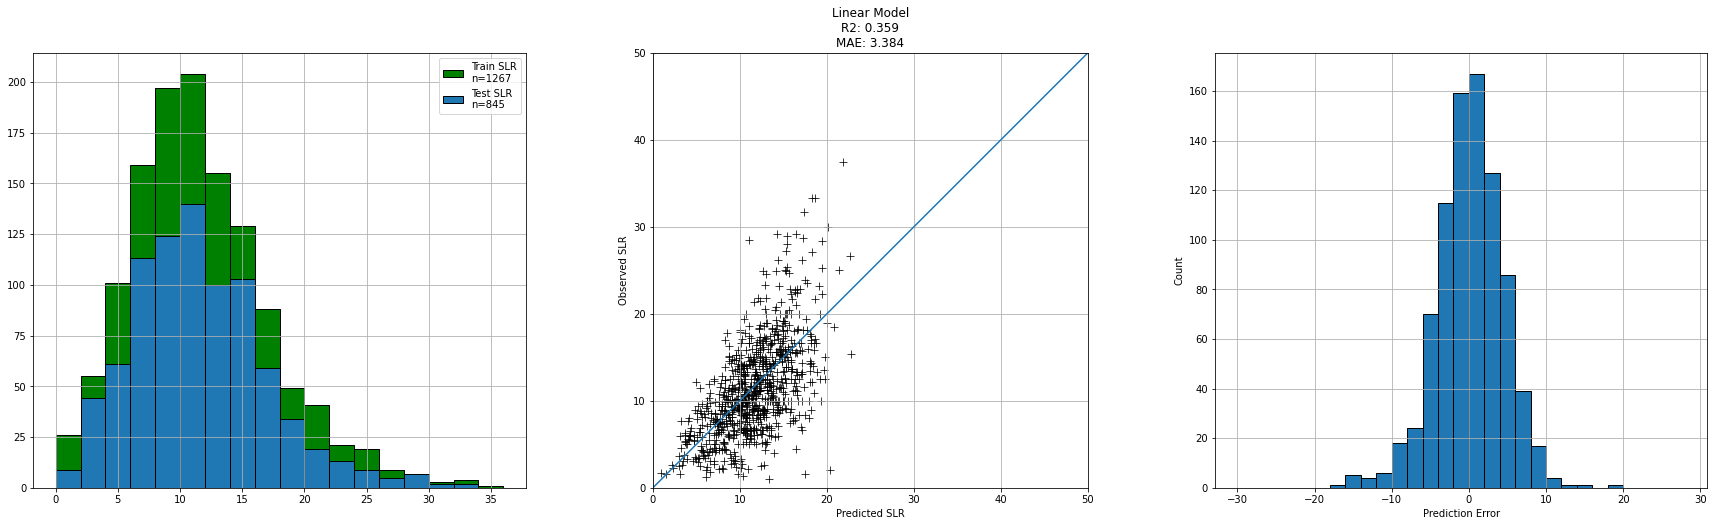

In [18]:

test_predictions = lr.predict(X_test_norm)
lr_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
maxslr = 50
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('Linear Model\nR2: %.3f\nMAE: %.3f'%(lr_test_score, lr_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

# fig.suptitle('MultiLayer Perceptron (Simple ANN) [%d Hidden Layer Sizes]'%layer_sizes)

In [19]:
from sklearn.neural_network import MLPRegressor

for layer_sizes in [1000]:
    mlp = MLPRegressor(
        hidden_layer_sizes=(layer_sizes,), 
        activation='relu', 
        solver='sgd', 
        alpha=0.00001, 
        batch_size='auto', 
        learning_rate='adaptive', 
        learning_rate_init=0.01, 
        power_t=0.5, 
        max_iter=50000, 
        shuffle=True, 
        random_state=5, 
        tol=0.0001, 
        verbose=False, 
        warm_start=False, 
        momentum=0.7, 
        nesterovs_momentum=True, 
        early_stopping=True, 
        validation_fraction=0.3, 
        beta_1=0.5, 
        beta_2=0.999, 
        epsilon=1e-8)

    mlp.fit(X_train_norm, y_train)

    mlp_train_score = mlp.score(X_train_norm, y_train)
    mlp_test_score = mlp.score(X_test_norm, y_test)
    
    # mlp_coeff_used = np.sum(mlp.coef_ != 0)

    print('Layer Sizes: %d'%layer_sizes)
    print('MLP Train Score: %.3f'%mlp_train_score)
    print('MLP Test Score: %.3f'%mlp_test_score)
    print()

Layer Sizes: 1000
MLP Train Score: 0.580
MLP Test Score: 0.379



Text(0.5, 0.98, 'MultiLayer Perceptron (Simple ANN) [1000 Hidden Layer Sizes]')

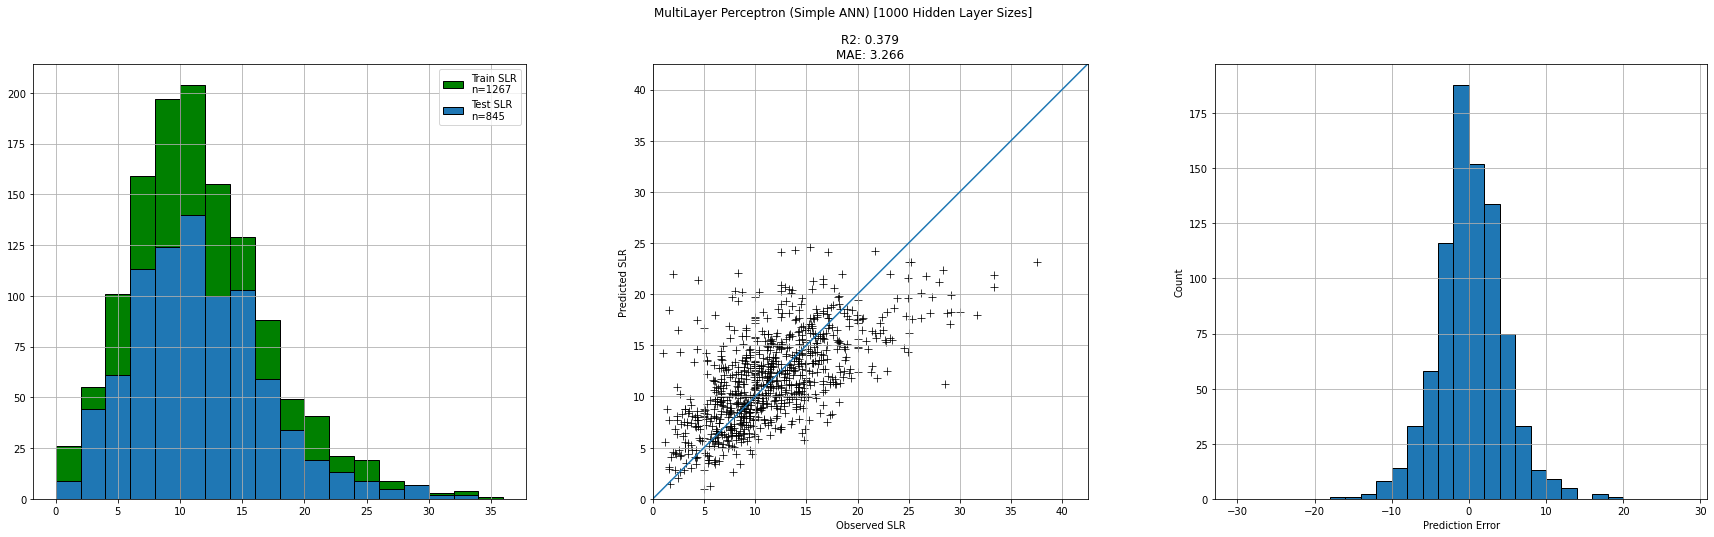

In [20]:
test_predictions = mlp.predict(X_test_norm)
mlp_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(y_test, test_predictions, c='k', s=50, marker='+', linewidth=0.75)
ax.set_xlabel('Observed SLR')
ax.set_ylabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('R2: %.3f\nMAE: %.3f'%(mlp_test_score, mlp_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

fig.suptitle('MultiLayer Perceptron (Simple ANN) [%d Hidden Layer Sizes]'%layer_sizes)